<a href="https://colab.research.google.com/github/furio1999/Fulvio.github.io/blob/main/MLEx13_CNNEnsembles_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Exercise 13

# CNN Ensembles - CIFAR10 



##Import 

Import libraries and print some versions.

To use GPU, set `Edit / Notebook settings / Hardware accelerator` to **GPU**.

In [ ]:
%tensorflow_version 2.x

import numpy as np
import tensorflow as tf
import keras

print("Tensorflow version %s" %tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.3.0
Found GPU at: /device:GPU:0


## Load data

Load training data from Keras library




In [ ]:
def load_cifar10():
    # load data
    (Xtrain,Ytrain), (Xtest, Ytest) = keras.datasets.cifar10.load_data()
    print(Ytrain.shape)
    # get information
    ninput = Xtrain.shape[0]
    imgsize = (Xtrain.shape[1], Xtrain.shape[2])
    input_shape = (Xtrain.shape[1], Xtrain.shape[2], Xtrain.shape[3])
    ntest = Xtest.shape[0]
    num_classes = np.max(np.unique(Ytrain)) + 1
    print("Training input %s" %str(Xtrain.shape))
    print("Training output %s" %str(Ytrain.shape))
    print("Test input %s" %str(Xtest.shape))
    print("Test output %s" %str(Ytest.shape))
    print("Input shape: %s" %str(input_shape))
    print("Number of classes: %d" %num_classes)

    # normalize input to [0,1]
    Xtrain = Xtrain / 255.0
    Xtest = Xtest / 255.0
    
    # Transform output to one-out-of-n encoding
    Ytrain = keras.utils.to_categorical(Ytrain, num_classes)
    Ytest = keras.utils.to_categorical(Ytest, num_classes)
    
    return [Xtrain,Ytrain,Xtest,Ytest,input_shape,num_classes]

[Xtrain,Ytrain,Xtest,Ytest,input_shape,num_classes] = load_cifar10()

170500096/170498071 [==============================] - 2s 0us/step
(50000, 1)
Training input (50000, 32, 32, 3)
Training output (50000, 1)
Test input (10000, 32, 32, 3)
Test output (10000, 1)
Input shape: (32, 32, 3)
Number of classes: 10


## Show random image



5


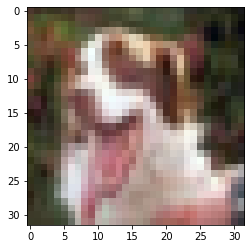

In [ ]:
import matplotlib.pyplot as plt
import random

i = random.randrange(0,Xtrain.shape[0])
image = Xtrain[i]
image = np.array(image, dtype='float')

label = Ytrain[i].argmax()  # categorical from one-hot-encoding
print(label)

plt.imshow(image, cmap='gray')
plt.show()


##CNN ensemble model


In [ ]:
from keras.models import Model
from keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPool2D, Input
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import optimizers

# single model
def CNN(input_shape, num_classes, base_width=16, depth=4):
    
    inputs = Input(input_shape)
    
    image_size = input_shape[0]
    filters = base_width

    # feature extractor
    for i in range(depth):
        if i == 0:
            x = Conv2D(filters=filters,
                       kernel_size = 3,
                       activation="relu",
                       strides=1,
                       padding="same")(inputs)
        else:
            x = Conv2D(filters=filters,
                       kernel_size = 3,
                       activation="relu",
                       strides=1,
                       padding="same")(x)
            
        x = MaxPool2D()(x)
        filters *= 2
    
    x = Flatten()(x) 
    x = Dropout(0.4)(x)
    
    outputs = Dense(num_classes, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# ensemble model
def Ensemble(ens_dim, input_shape, num_classes, base_width=16, depth=4):
  inputs = Input(shape=input_shape)
  
  learners = [CNN(input_shape,
                  num_classes,
                  base_width,
                  depth) for _ in range(ens_dim)]
  
  outputs = [learners[i](inputs) for i in range(ens_dim)]
  
  ensemble_model = Model(inputs, outputs, name="ensemble_model")
  optimizer = 'adam'
  # an independent loss for each model
  losses = ["categorical_crossentropy" for _ in range(ens_dim)]
  ensemble_model.compile(loss=losses, optimizer=optimizer, metrics=['accuracy'])
  return ensemble_model


# create the ensemble model
ens_dim = 3
model = Ensemble(ens_dim, input_shape, num_classes)
model.summary()

# single model summary
model.get_layer(index=-1).summary()

Model: "ensemble_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
functional_19 (Functional)      (None, 10)           102570      input_22[0][0]                   
__________________________________________________________________________________________________
functional_21 (Functional)      (None, 10)           102570      input_22[0][0]                   
__________________________________________________________________________________________________
functional_23 (Functional)      (None, 10)           102570      input_22[0][0]                   
Total params: 307,710
Trainable params: 307,710
Non-trainable params: 0
_____________

## Train

In [ ]:
epochs = 10
history = model.fit(Xtrain, [Ytrain for _ in range(ens_dim)], batch_size=32, epochs=epochs, validation_data = (Xtest,[Ytest for _ in range(ens_dim)]))

Epoch 1/10
1563/1563 [==============================] - 16s 10ms/step - loss: 4.7030 - functional_19_loss: 1.5645 - functional_21_loss: 1.5617 - functional_23_loss: 1.5767 - functional_19_accuracy: 0.4259 - functional_21_accuracy: 0.4245 - functional_23_accuracy: 0.4202 - val_loss: 3.7866 - val_functional_19_loss: 1.2675 - val_functional_21_loss: 1.2508 - val_functional_23_loss: 1.2683 - val_functional_19_accuracy: 0.5535 - val_functional_21_accuracy: 0.5511 - val_functional_23_accuracy: 0.5486
Epoch 2/10
1563/1563 [==============================] - 15s 10ms/step - loss: 3.6082 - functional_19_loss: 1.1960 - functional_21_loss: 1.2004 - functional_23_loss: 1.2119 - functional_19_accuracy: 0.5743 - functional_21_accuracy: 0.5702 - functional_23_accuracy: 0.5633 - val_loss: 3.2571 - val_functional_19_loss: 1.1108 - val_functional_21_loss: 1.0635 - val_functional_23_loss: 1.0828 - val_functional_19_accuracy: 0.6184 - val_functional_21_accuracy: 0.6259 - val_functional_23_accuracy: 0.6173


##Evaluate the model

## Compare single networks with ensemble


In [ ]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# accuracy
ind_test_acc = []
ind_test_acc_profile = []
for key in history.history.keys():
  if ("val" in key) and ("accuracy" in key):
    ind_test_acc.append(history.history[key][-1])
    ind_test_acc_profile.append(history.history[key])
print("Single models test accuracy: ", ind_test_acc)

# ensemble test accuracy
preds = np.array(model.predict(Xtest))
# average over the ensemble
preds_ens = np.mean(preds, axis=0)
ens_test_acc = accuracy_score(np.argmax(Ytest, axis=-1), np.argmax(preds_ens, axis=-1))
print("Ensemble test accuracy: ", ens_test_acc)

Single models test accuracy:  [0.7218999862670898, 0.732200026512146, 0.7279999852180481]
Ensemble test accuracy:  0.7675


Text(0.5, 0, 'epoch')

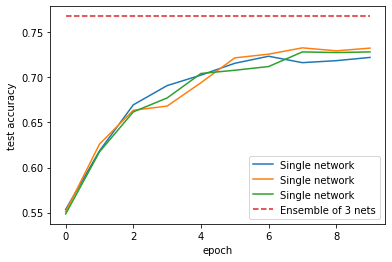

In [ ]:
plt.plot(np.transpose(ind_test_acc_profile), label="Single network")
plt.plot([ens_test_acc for _ in range(len(history.history[key]))], linestyle="--", label="Ensemble of {} nets".format(ens_dim))
plt.legend()
plt.ylabel('test accuracy')
plt.xlabel('epoch')

# Home Exercises

**Question 1** 

Evaluate the performance of ensembles varying the number of base members.